# CS-6600 Assignment #4 - Binary Classification

**YOUR NAME HERE**

*Weber State University*

This assignment is a bit of a right of passage in the machine learning community. It's a binary classification problem based upon a famous historic event - [the sinking of the Titanic](https://en.wikipedia.org/wiki/Titanic).

For reference, the RMS Titanic was a British passenger liner which sank in the North Atlantic Ocean on April 15th, 1912 after striking an iceberg during its maiden voyage from Southampton, England to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time, and it remains the deadliest sinking of an ocean liner or cruise ship.

It was also notable because there were quite a few hours between when the ship struck the iceberg and when it went under, and most of those who survived did so by boarding lifeboats. In other words, there was a (noisy and nonuniform) process that determined who would be on the lifeboats and who would not, and this process mostly determined who survived.

For this assignment, we're going to try to predict who survives based upon known passenger information.

*Note* - Whether a passenger was on a floating door isn't one of the variables.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1Tb7l6nDAQog3imqv24znRQiMcUkm_dUY" alt="Titanic Door">
</center>

The variables we will have are:

|*Variable* |*Description* |*Details* |
|:----|:----|:----|
|survival|Whether the passenger survived|0 = No, 1 = Yes|
|pclass|The passenger class of the ticket|1 = 1st, 2 = 2nd, 3 = 3rd|
|name| First and last name of the passenger||
|sex|The gender of the passenger||
|age|The age of the passenger||
|sibsp|The number of siblings / spouses on the ship with the passenger||
|parch|The number of parents / children on the ship with the passenger||
|ticket|The ticket number||
|fare|The cost of the ticket||
|embarked|The port of embarcation for the passenger|C = Cherbourg, Q = Queenstown, S = Southampton|

Note that we're using a slightly modified and cleaned version of the commonly available Titanic dataset. Before we import the data, we'll first import our favorite libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

And then, we'll grab some more.

In [4]:
import seaborn as sns #Data visualization library based on matplotlib

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Now, let's get the dataset. The code below should let you import if from my (Dylan's) Google Drive.

In [5]:
#Import the Titanic data
url = 'https://drive.google.com/uc?export=download&id=1Oytm0kGCmWsydZrRvCyK_cOE2WfnaVIA'
titanic_col_names = ['PassengerID','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked']
titanic = pd.read_csv(url,header=0,names=titanic_col_names)
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,159,0,3,"Smiljanic, Mr. Mile",male,25.0,0,0,315037,8.6625,S
1,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,S
2,224,0,3,"Nenkoff, Mr. Christo",male,25.0,0,0,349234,7.8958,S
3,532,0,3,"Toufik, Mr. Nakli",male,25.0,0,0,2641,7.2292,C
4,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S


I'll also import the seaborn data visualization library based on matplotlib, set a couple style parameters, and get rid of some annoying warnings.

In [6]:
#import seaborn as sns #Data visualization library based on matplotlib

#Set some style parameters for seaborn
#sns.set(style="white") #white background style for seaborn plots
#sns.set(style="whitegrid", color_codes=True)
#Get rid of some annying warnings
#import warnings
#warnings.simplefilter(action='ignore')

Have you heard the phrase "women and children first?" Well, it relates to the [code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) that is supposed to be practiced in a life-threatening situation. Let's see if it's a decent predictor on the Titanic. In particulary, let's look at how survival percentage broke down by gender.

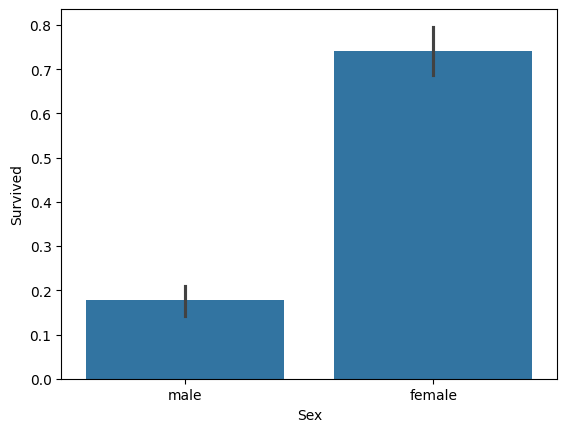

In [7]:
#Examine survival by gender
sns.barplot(x='Sex',y='Survived', data=titanic)
plt.show()

Whoa! Looks like many more men went down with the ship. Now, let's take a look at survival rates based on age, and see how well the "children" aspect of that dictum holds up.

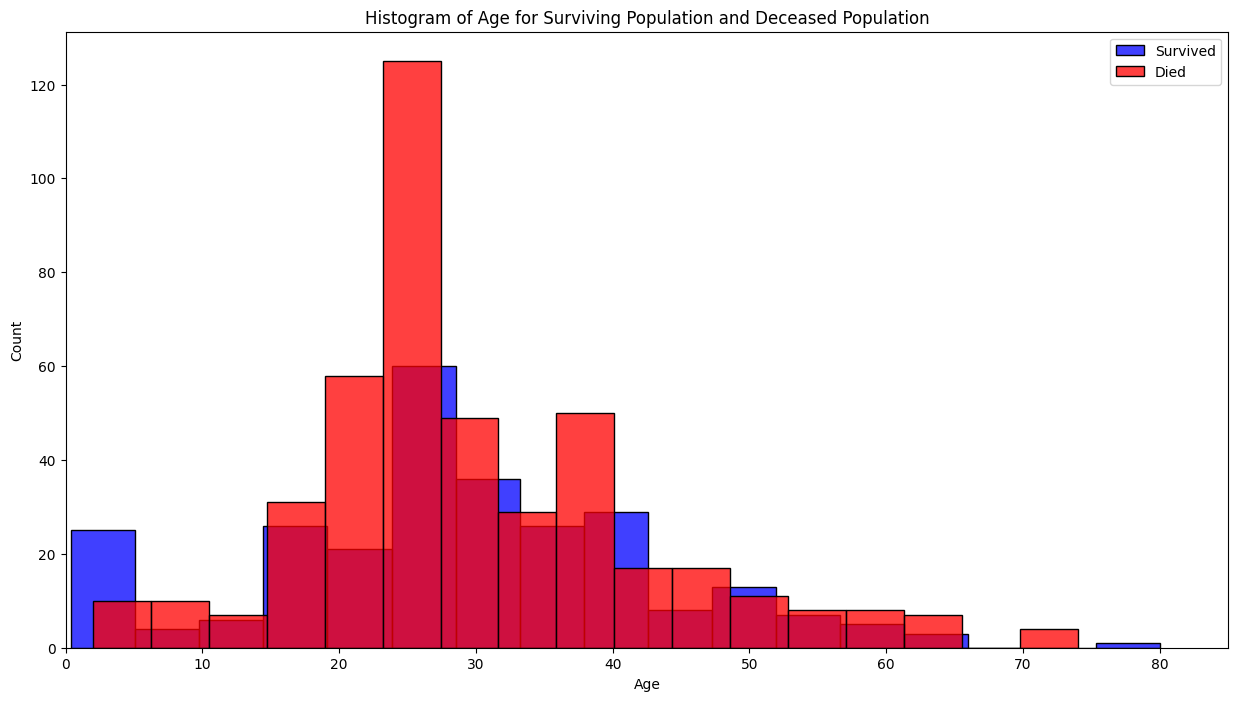

In [8]:
#Survival by age histogram
plt.figure(figsize=(15,8))
sns.histplot(titanic["Age"][titanic.Survived == 1], label='Survived', color='blue', bins=17, kde=False)
sns.histplot(titanic["Age"][titanic.Survived == 0], label='Died', color='red', bins=17, kde=False)
plt.legend(['Survived', 'Died'])
plt.title('Histogram of Age for Surviving Population and Deceased Population')
plt.xlabel('Age')
plt.xlim(0,85)
plt.show()

OK, it looks like being a child did make one more likely to survive as well.

Let's use these two characteristics - age and gender - to build a decision tree predictive model.

First, we're going to want to convert our gender data column into a numeric one. So, we'll create a dummy "male" variable.

In [9]:
#Create a dummy "male" variable
#WARNING - If you run this twice, you'll create two distinct dummy variable columns
gender = pd.get_dummies(titanic["Sex"],drop_first=True)
titanic = pd.concat([titanic,gender], axis='columns')
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male
0,159,0,3,"Smiljanic, Mr. Mile",male,25.0,0,0,315037,8.6625,S,True
1,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,S,True
2,224,0,3,"Nenkoff, Mr. Christo",male,25.0,0,0,349234,7.8958,S,True
3,532,0,3,"Toufik, Mr. Nakli",male,25.0,0,0,2641,7.2292,C,True
4,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S,False


Then we'll create a dependent and independent variable for the logistic regression model.

In [10]:
#Create the dependent and independent variable for the logistic model
X = titanic[["Age","male"]]
y = titanic["Survived"]

We'll split our data into a training dataset and a test dataset.

In [11]:
#Split the data into training data and test data, 75/25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)

Then, we'll build our decision tree predictive model.

In [12]:
#Build the logistic model using the Fare variable
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train);

We can graph visualize this decision tree with the code below.

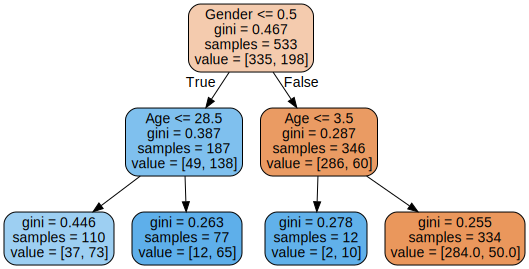

In [13]:
export_graphviz(
        tree_clf,
        out_file=str("titanic_decision_tree.dot"),
        feature_names=["Age", "Gender"],
        rounded=True,
        filled=True
    )
Source.from_file("titanic_decision_tree.dot")

It looks like it first splits on gender, and then on age, but the age split is very different for the men and women.

Now, we'll use this model to predict survival in the test dataset.

In [14]:
#Use the model to predict the y values in the test set.
y_pred = tree_clf.predict(X_test[["Age","male"]])
#Create the confusion matrix
confusion_matrix(y_test,y_pred)

array([[89, 17],
       [18, 54]])

We can check our accuracy, precision, and recall:

In [15]:
#Check the accuracy, precision, and recall
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))

Accuracy: 0.8033707865168539
Precision: 0.7605633802816901
Recall: 0.75


Grab the probabilities for the ROC curve:

In [16]:
#Get the probabilities for the ROC curve
pred_prob = tree_clf.predict_proba(X_test[["Age","male"]])
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1],pos_label=1)

Finally, graph the ROC curve and get the AUC score:

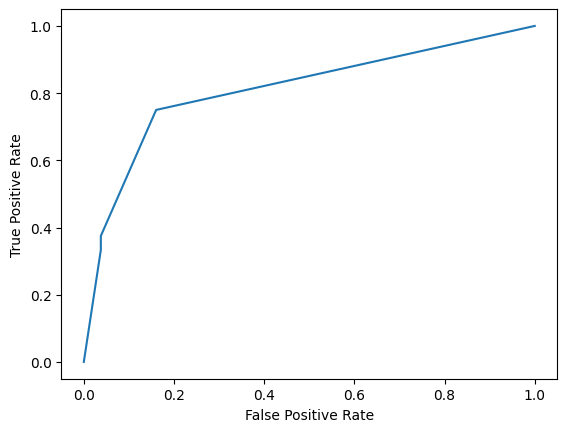

0.8099449685534591

In [17]:
#Graph the ROC curve and display the AUC score
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_test,pred_prob[:,1])

An AUC of .81 isn't great, but it's not terrible. For this assignment, you're going to see if you can do better.

The rules are:

- You need to use a logistic regression model.
- You can only use tha data provided in the dataset, and obviously you can't use "survival" (the variable you want to predict) as a predictor.
- You should build your model on the training data produced above, and test it (ROC curve and AUC score) on the test data produced above.

Do some data exploration, try to figure out a good model, and prove the ROC curve and AUC score for the one you find. Please chart the ROC curve and provide the AUC score as above. Full credit will be awarded if you can find an AUC above .8, and a bonus will go to whoever in the class can produce the best model as measured by AUC score on the test dataset.

*Hint* - It helps to be rich.

The assignment is this - do some data exploration and try to figure out a good model. Use random forest as your predictor, and do some data exploration to figure out which variables you want to use, and why.

Once you've got a good model, please chart the ROC curve and provide the AUC score as above.

I'll run your model on a test dataset, with extra credit and glory to whoever gets the highest AUC.

### Notes

*  [The Titanic competition on Kaggle](https://www.kaggle.com/competitions/titanic).
*  [Soundtrack](https://www.youtube.com/watch?v=9bFHsd3o1w0) (Could there by any other option?)



AUC Score: 0.8485324947589098


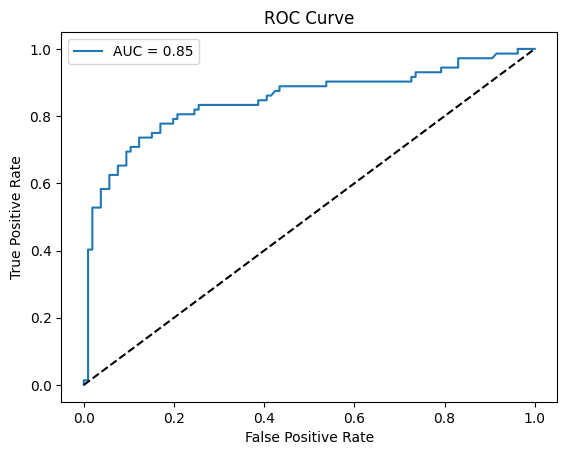

In [24]:
#Your work here.
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#Your work here.

# Example: Create a 'FamilySize' feature
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1

# Select features for the model
features = ['Pclass', 'Age', 'Fare', 'FamilySize', 'male']
# 'male' is the dummy variable created earlier
X = titanic[features]
y = titanic['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1912)

# Handle missing values (e.g., impute with the mean for 'Age')
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)
X_test['Age'].fillna(X_test['Age'].mean(), inplace=True)


# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()